# Lab1 手写体识别

- 姓名:于洋淼
- 学号:2113644
- 专业:物联网工程

## 导入需要的包

In [60]:
# 实现knn使用的包
import numpy as np
from collections import Counter
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# 实现ResNet使用的包
import torch
import torch.nn as nn

# 自定义DataSet使用的包
import torch
from torch.utils.data import Dataset
import pandas as pd

# 图像增广使用的包
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch

# 实现cnn使用的包
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


## 导入数据集

In [61]:
def load_image_data(filename):
    # 打开文件并读取数据
    with open(filename, 'r') as file:
        lines = file.readlines()

    # 计算数据行数
    num_lines = len(lines)

    # 初始化返回的数据矩阵和类别向量
    return_mat = np.zeros((num_lines, 256))
    return_class_vector = np.zeros((num_lines, 1))

    # 逐行处理数据
    for i in range(num_lines):
        line = lines[i].strip().split()

        # 将数据转换为浮点数并填充到return_mat
        for j in range(256):
            return_mat[i][j] = float(line[j])

        # 计算类别并填充到return_class_vector
        cl_count = 0
        for j in range(256, 266):
            if line[j] != '1':
                cl_count += 1
            else:
                break
        return_class_vector[i] = cl_count

    return return_mat, return_class_vector

### 导入数据

In [62]:
X, y = load_image_data('semeion.data')
np.shape(X), np.shape(y)

print(X.shape)
print(y.shape)

(1593, 256)
(1593, 1)


### 查看数据集样本是否平衡

In [63]:
# 使用 numpy 的 unique 函数获取独特的数字和它们的计数
unique_numbers, counts = np.unique(y, return_counts=True)

# 打印独特的数字和它们的计数
for num, count in zip(unique_numbers, counts):
    print(f"数字 {num} 出现了 {count} 次")


数字 0.0 出现了 161 次
数字 1.0 出现了 162 次
数字 2.0 出现了 159 次
数字 3.0 出现了 159 次
数字 4.0 出现了 161 次
数字 5.0 出现了 159 次
数字 6.0 出现了 161 次
数字 7.0 出现了 158 次
数字 8.0 出现了 155 次
数字 9.0 出现了 158 次


可以看到数据集中样本比较平衡，因此在之后的cnn实现中我们只使用accuracy作为评价指标

## 基本要求
编程实现kNN算法；给出不同k值（1，3，5）情况下，kNN算法对手写数字的识别精度（使用留一法）

In [64]:
def my_knn_classifier(X, y, neighbors):
    avg_acc = 0
    loo = LeaveOneOut()  # 创建 Leave-One-Out 分割器

    # 使用留一法进行交叉验证
    for train, test in loo.split(X, y):
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
        train_shape = X_train.shape[0]
        test_shape = X_test.shape[0]
        test_res = []
        acc = 0

        # 遍历测试集中的每个样本
        for i in range(test_shape):
            test_diff_mat = np.tile(X_test[i], (train_shape, 1)) - X_train
            sq_test_diff_mat = test_diff_mat ** 2
            sq_test_diff_dis = sq_test_diff_mat.sum(axis=1)
            test_diff_dis = sq_test_diff_dis ** 0.5
            sort_index = np.argsort(test_diff_dis)
            label_count = []

            # 获取最近的 k 个邻居的标签
            for j in range(neighbors):
                label_count.append(y_train[sort_index[j]][0])

            classify_res = Counter(label_count)
            classify_res = classify_res.most_common(2)[0][0]
            test_res.append(classify_res)

            if classify_res == y_test[i]:
                acc += 1

        avg_acc += acc

    acc_rate = avg_acc / len(X)
    print('使用自己实现的knn，k={0}时，准确率为：{1}'.format(neighbors, acc_rate))
    return acc_rate

### 不同k值下的准确率

In [65]:
my_knn_classifier(X, y, 1)
my_knn_classifier(X, y, 3)
my_knn_classifier(X, y, 5)

使用自己实现的knn，k=1时，准确率为：0.9158819836785939
使用自己实现的knn，k=3时，准确率为：0.9190207156308852
使用自己实现的knn，k=5时，准确率为：0.9152542372881356


0.9152542372881356

## 中级要求
与机器学习包中的knn(sklearn.neighbors.KNeighborsClassifier)分类结果进行对比
同样使用留一法

In [66]:
def knn_classifier(X, y, neighbors):
    loo = LeaveOneOut()
    knn = KNeighborsClassifier(n_neighbors=neighbors)
    accuracies = []  # 存储每个测试样本的准确性

    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # 训练模型
        knn.fit(X_train, y_train.ravel())

        # 预测
        y_pred = knn.predict(X_test)

        # 计算准确性
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # 计算平均准确性
    average_accuracy = sum(accuracies) / len(accuracies)
    print('使用机器学习包实现的knn，k={0}时，准确率为：{1}'.format(neighbors, average_accuracy))
    return average_accuracy

### 不同k值下的准确率

In [67]:
knn_classifier(X, y, 1)
knn_classifier(X, y, 3)
knn_classifier(X, y, 5)

使用机器学习包实现的knn，k=1时，准确率为：0.9171374764595104
使用机器学习包实现的knn，k=3时，准确率为：0.903954802259887
使用机器学习包实现的knn，k=5时，准确率为：0.9052102950408035


0.9052102950408035

## 对比自己实现的knn分类器和机器学习包中的knn分类器
选取k值为1到20绘制图像
由图像可见两个分类器随着k值增加大体上都是由欠拟合到最佳k值到过拟合

使用自己实现的knn，k=1时，准确率为：0.9158819836785939
使用机器学习包实现的knn，k=1时，准确率为：0.9171374764595104
使用自己实现的knn，k=2时，准确率为：0.9158819836785939
使用机器学习包实现的knn，k=2时，准确率为：0.8801004394224733
使用自己实现的knn，k=3时，准确率为：0.9190207156308852
使用机器学习包实现的knn，k=3时，准确率为：0.903954802259887
使用自己实现的knn，k=4时，准确率为：0.9196484620213434
使用机器学习包实现的knn，k=4时，准确率为：0.9045825486503453
使用自己实现的knn，k=5时，准确率为：0.9152542372881356
使用机器学习包实现的knn，k=5时，准确率为：0.9052102950408035
使用自己实现的knn，k=6时，准确率为：0.9190207156308852
使用机器学习包实现的knn，k=6时，准确率为：0.9033270558694287
使用自己实现的knn，k=7时，准确率为：0.9221594475831764
使用机器学习包实现的knn，k=7时，准确率为：0.9096045197740112
使用自己实现的knn，k=8时，准确率为：0.9240426867545511
使用机器学习包实现的knn，k=8时，准确率为：0.9058380414312618
使用自己实现的knn，k=9时，准确率为：0.9234149403640929
使用机器学习包实现的knn，k=9时，准确率为：0.911487758945386
使用自己实现的knn，k=10时，准确率为：0.9196484620213434
使用机器学习包实现的knn，k=10时，准确率为：0.9045825486503453
使用自己实现的knn，k=11时，准确率为：0.9139987445072191
使用机器学习包实现的knn，k=11时，准确率为：0.9096045197740112
使用自己实现的knn，k=12时，准确率为：0.9165097300690521
使用机器学习包实现的knn，k=12时，准确率为：0.9077212806026366


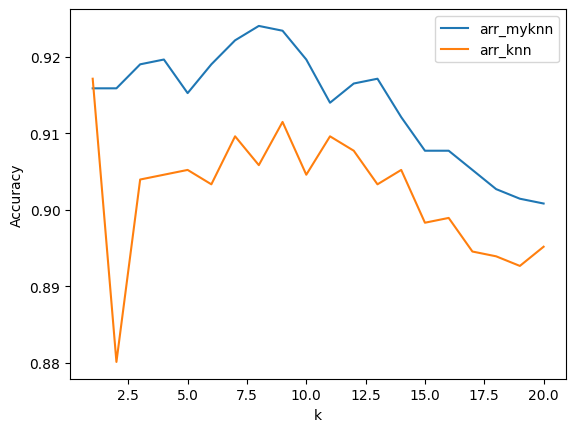

In [68]:
arr_myknn=[]
arr_knn=[]
for k in range(1, 21):
    arr_myknn.append((k, my_knn_classifier(X, y, k)))
    arr_knn.append((k, knn_classifier(X, y, k)))

print(arr_myknn)
print(arr_knn)

x_myknn = [x[0] for x in arr_myknn]
y_myknn = [x[1] for x in arr_myknn]

x_knn = [x[0] for x in arr_knn]
y_knn = [x[1] for x in arr_knn]

# 绘制图像
plt.plot(x_myknn, y_myknn, label='arr_myknn')
plt.plot(x_knn, y_knn, label='arr_knn')

plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend()  # 显示图例
plt.show()

## 高级要求
采用旋转等手段对原始数据进行处理，扩增数据量，采用CNN或其他深度学习方法实现手写体识别

### 图像增广
我没有自己动手实现图像增广，而是调用了Keras库中的图像预处理类ImageDataGenerator

#### 保存验证集
由于图像增广是基于原数据进行增广，如果增广后再分割验证集，可能会造成数据泄露，所以这里提前分割出10%作为验证集

In [69]:
combined_data = np.hstack((X, y))
# 分割验证集
combined_data1, val_data = train_test_split(combined_data, test_size=0.1, random_state=42)
# 将验证集保存在csv中
combined_df_val = pd.DataFrame(val_data)
combined_df_val.to_csv('data_val.csv', index=False, header=False)

#### 恢复图像
ImageDataGenerator输入是四维的图像数据集(样本数, 长, 宽, 通道数)，我们的样本是16*16的灰度图像。


In [70]:
# 将特征和label分割
X_t = combined_data1[:, :-1]
y_t = combined_data1[:, -1]
y_t = y_t.reshape(-1, 1)

# 将X恢复为四维的图像数据集
X_change = np.reshape(X_t, (-1, 16, 16))
X_change = np.expand_dims(X_change, axis=-1)
print(X_change.shape)

(1433, 16, 16, 1)


#### 创建ImageDataGenerator

由于我们是要识别数字，左右反转、上下颠倒的方式处理图像势必会影响正确性，所以这里我最开始选择的策略有三种
- 随机在-10到+10度之间旋转
- 随机在10%的范围内水平移动
- 随机在10%的范围内垂直移动

在查看ImageDataGenerator的参数列表时，发现了ZCA白化的选项，可以降低特征之间的相关性，相比于常用的减少冗余的方式PCA，ZCA可以保持特征维度不发生改变(更细致的了解后发现ZCA实际上就是在PCA的基础上，将数据旋转回原来的特征空间)

最终选择了两种数据增广的方式，生成两份增广后的数据集再进行合并

In [71]:
# 第一种增广策略
datagen1 = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
)
# 第二种增广策略
datagen = ImageDataGenerator(zca_whitening=True, featurewise_center=True)

#### 合并数据集并保存
将开始的X,y与增广出来的数据集合并并保存在csv中

In [72]:
augmented_data = []

for image in X_change:
    augmented_image = datagen.random_transform(image)
    augmented_data.append(augmented_image)

augmented_data3 = []

for image in X_change:
    augmented_image = datagen1.random_transform(image)
    augmented_data3.append(augmented_image)

# 生成增强后的数据集
augmented_data = np.array(augmented_data).reshape(-1, 256)
augmented_data3 = np.array(augmented_data3).reshape(-1, 256)

# 与label合并
combined_data2 = np.hstack((augmented_data, y_t))
combined_data3 = np.hstack((augmented_data3, y_t))

# 数据集合并
data = np.vstack((combined_data1, combined_data2, combined_data3))
print(data.shape)

# 将合并后的数据转换为 Pandas DataFrame
combined_df = pd.DataFrame(data)

# 保存到 CSV 文件
combined_df.to_csv('data.csv', index=False, header=False)

(4299, 257)


### DataSet
自定义DataSet，将csv转化为DataSet并进行归一化处理

In [73]:
class DiabetesDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file, header=None)

        # Calculate mean and standard deviation for normalization
        self.mean = self.data.iloc[:, :-1].mean().values
        self.std = self.data.iloc[:, :-1].std().values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load features (all columns except the last one)
        features = self.data.iloc[idx, :-1].values.astype(float)

        # Apply normalization to features
        normalized_features = (features - self.mean) / self.std

        # Load label (last column)
        label = int(self.data.iloc[idx, -1])

        return torch.tensor(normalized_features, dtype=torch.float32), label

## 自定义RseNet
自定义实现的ResNet由四层网络组成，第一层是特征提取和归一化层，后面三层均由多个残差块和注意力机制块组成(此处实现resnet没有从sklearn从0实现，最开始尝试使用pytorch预训练的resnet18，但是效果不是特别好)

### 注意力机制(ECABlock)
本次实验使用的注意力机制是通过ECA模块组成，该模块分成两部分
- 通过一个平均池化层和一个卷积层计算出注意力权重向量v
- 返回x*v的甲醛特征值

### ResNet实现细节
1. **输入和基础卷积层**：
   - 输入是一个1维的信号或时间序列（通道数为1）。
   - 第一个卷积层(`self.conv1`)有64个输出通道，使用7x1大小的卷积核，步幅为2，填充为3，没有偏置项。
   - 接着使用批标准化 (`self.bn1`) 和 ReLU 激活函数进行激活。

2. **池化层**：
   - 使用1维的最大池化层 (`self.maxpool`) 对特征进行下采样。

3. **残差块**：
   - 模型包含多个残差块，以增加网络深度和性能。
   - 这些残差块包含两个卷积层，每个卷积层后都有批标准化和 ReLU 激活函数。
   - 在每个残差块内，特征的维度保持不变，因为卷积核的大小、步幅和填充都被设置为1。
   - 在残差块内，将残差连接（`x`）与块内部的输出相加。

4. **通道注意力机制**：
   - 在残差块之后，使用`ECABlock`，进一步提高特征选择的性能。

5. **暂退法**：
   - 在输入层和卷积层后使用Dropout层，以防止过拟合。

6. **全局平均池化和全连接层**：
   - 最后，对特征进行全局平均池化(`self.avgpool`)，将特征压缩成一个全局平均值。
   - 然后，通过全连接层(`self.fc`)将特征映射到最终的输出类别数量（`num_class`）上。


In [74]:
class ECABlock(nn.Module):
    def __init__(self, channels, gamma=2, b=1):
        super(ECABlock, self).__init__()
        kernel_size = 3
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=kernel_size, padding=(kernel_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        v = self.avg_pool(x)
        v = self.conv(v.transpose(-1, -2)).transpose(-1, -2)
        v = self.sigmoid(v)
        return x * v

class MyResNetD_Plus(nn.Module):
    def __init__(self, num_class):
        super(MyResNetD_Plus, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=False)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.layer10conv1 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer10bn1 = nn.BatchNorm1d(64)
        self.layer10conv2 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer10bn2 = nn.BatchNorm1d(64)

        self.layer11conv1 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer11bn1 = nn.BatchNorm1d(64)
        self.layer11conv2 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer11bn2 = nn.BatchNorm1d(64)

        self.layer12conv1 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer12bn1 = nn.BatchNorm1d(64)
        self.layer12conv2 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer12bn2 = nn.BatchNorm1d(64)

        self.layer1att = ECABlock(64)

        self.layer20conv1 = nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1, bias=False)
        self.layer20bn1 = nn.BatchNorm1d(128)
        self.layer20conv2 = nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer20bn2 = nn.BatchNorm1d(128)
        self.layer20downsample0 = nn.Conv1d(64, 128, kernel_size=1, stride=2, bias=False)
        self.layer20downsample1 = nn.BatchNorm1d(128)

        self.layer21conv1 = nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer21bn1 = nn.BatchNorm1d(128)
        self.layer21conv2 = nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer21bn2 = nn.BatchNorm1d(128)

        self.layer22conv1 = nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer22bn1 = nn.BatchNorm1d(128)
        self.layer22conv2 = nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer22bn2 = nn.BatchNorm1d(128)

        self.layer23conv1 = nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer23bn1 = nn.BatchNorm1d(128)
        self.layer23conv2 = nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer23bn2 = nn.BatchNorm1d(128)

        self.layer2att = ECABlock(128)

        self.layer30conv1 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer30bn1 = nn.BatchNorm1d(256)
        self.layer30conv2 = nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer30bn2 = nn.BatchNorm1d(256)
        self.layer30downsample0 = nn.Conv1d(128, 256, kernel_size=1, stride=1, bias=False)
        self.layer30downsample1 = nn.BatchNorm1d(256)

        self.layer31conv1 = nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer31bn1 = nn.BatchNorm1d(256)
        self.layer31conv2 = nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer31bn2 = nn.BatchNorm1d(256)

        self.layer3att = ECABlock(256)
        self.dropout = nn.Dropout(0.2)

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, num_class)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool(x)

        # layer1 0
        identity = x
        x = self.layer10conv1(x)
        x = self.layer10bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer10conv2(x)
        x = self.layer10bn2(x)
        x += identity
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer1att(x)

        # layer1 1
        identity = x
        x = self.layer11conv1(x)
        x = self.layer11bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer11conv2(x)
        x = self.layer11bn2(x)
        x += identity
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer1att(x)

        # layer1 2
        identity = x
        x = self.layer12conv1(x)
        x = self.layer12bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer12conv2(x)
        x = self.layer12bn2(x)
        x += identity
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer1att(x)

        # layer2 0
        identity = x
        x = self.layer20conv1(x)
        x = self.layer20bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer20conv2(x)
        x = self.layer20bn2(x)
        identity = self.layer20downsample0(identity)
        identity = self.layer20downsample1(identity)
        x += identity
        x = self.relu(x)
        x = self.dropout(x)

        # layer2 1
        identity = x
        x = self.layer21conv1(x)
        x = self.layer21bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer21conv2(x)
        x = self.layer21bn2(x)
        x += identity
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2att(x)

        # layer2 2
        identity = x
        x = self.layer22conv1(x)
        x = self.layer22bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer22conv2(x)
        x = self.layer22bn2(x)
        x += identity
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2att(x)

        # layer2 3
        identity = x
        x = self.layer23conv1(x)
        x = self.layer23bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer23conv2(x)
        x = self.layer23bn2(x)
        x += identity
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2att(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


## 训练模型


### 前期准备
载入csv数据，并随机分割训练集测试集，创建Resnet模型、定义损失函数、优化器、训练轮数、学习率warmup轮数等

In [75]:
# 载入数据
csv_file = r'data.csv'
data = DiabetesDataset(csv_file=csv_file)
csv_val_file = r'data_val.csv'
val_data = DiabetesDataset(csv_file=csv_val_file)

# 使用cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 分割训练集、测试集
train_data, test_data = train_test_split(data, test_size=0.2, random_state=40)

# 创建dataloader
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False)

# 数字0-9，十个类别
num_classes = 10  # Number of classes

# 创建模型
model = MyResNetD_Plus(num_classes)
model.to(device)

# 定义损失函数
criterion = nn.CrossEntropyLoss()

# 保存模型和准确率
best_model = None
best_accuracy = 0.0

# 训练轮数
num_epochs = 250
# 准确率保存
train_accuracy_list = []
test_accuracy_list = []

# 优化器
optimizer = optim.Adam(model.parameters(), lr=0.005)

# 设置学习率调度器
warmup_epochs = 15
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs - warmup_epochs)
scheduler_warmup = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: epoch / warmup_epochs)

### 模型训练

Epoch [1/250], Train Loss: 2.3214, Train Accuracy: 0.1082
Test Accuracy: 0.0977
Epoch [2/250], Train Loss: 2.1893, Train Accuracy: 0.1623
Test Accuracy: 0.1128
Epoch [3/250], Train Loss: 1.9307, Train Accuracy: 0.2855
Test Accuracy: 0.1744
Epoch [4/250], Train Loss: 1.6283, Train Accuracy: 0.4330
Test Accuracy: 0.2407
Epoch [5/250], Train Loss: 1.2544, Train Accuracy: 0.5600
Test Accuracy: 0.4558
Epoch [6/250], Train Loss: 0.9452, Train Accuracy: 0.6577
Test Accuracy: 0.6756
Epoch [7/250], Train Loss: 0.7925, Train Accuracy: 0.7206
Test Accuracy: 0.7081
Epoch [8/250], Train Loss: 0.6476, Train Accuracy: 0.7761
Test Accuracy: 0.7151
Epoch [9/250], Train Loss: 0.5303, Train Accuracy: 0.8223
Test Accuracy: 0.8070
Epoch [10/250], Train Loss: 0.4953, Train Accuracy: 0.8427
Test Accuracy: 0.8593
Epoch [11/250], Train Loss: 0.3769, Train Accuracy: 0.8750
Test Accuracy: 0.8616
Epoch [12/250], Train Loss: 0.3983, Train Accuracy: 0.8665
Test Accuracy: 0.8512
Epoch [13/250], Train Loss: 0.3279, T

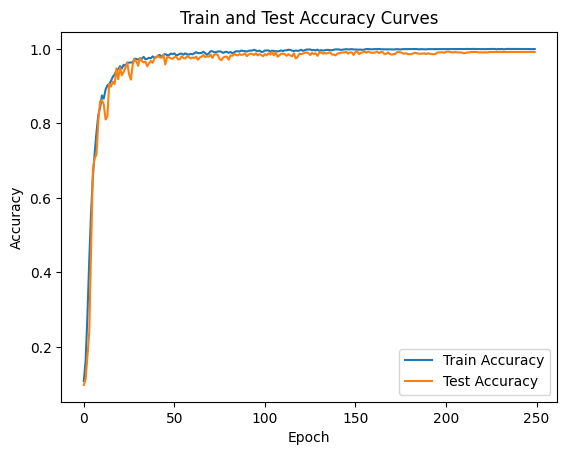

In [76]:
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        # 在gpu上训练
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.unsqueeze(1)
        # 梯度清零
        optimizer.zero_grad()
        # 预测值
        outputs = model(inputs)
        # 计算loss
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        # 根据梯度更新模型权重
        optimizer.step()
        # 更新统计量
        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    # 计算平均loss
    avg_loss = total_loss / len(train_data)
    # 计算平均acc
    train_accuracy = correct_train / total_train
    train_accuracy_list.append(train_accuracy)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    # 切换到评估状态，这时不会启用dropout层
    model.eval() 
    correct_test = 0
    total_test = 0
    # 在测试集上试验
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.unsqueeze(1)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = correct_test / total_test
    test_accuracy_list.append(test_accuracy)
    print(f'Test Accuracy: {test_accuracy:.4f}')

    # Update the best model if test accuracy is higher
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = model.state_dict()
        torch.save(best_model, 'best_model.pth')  # Save best model weights

    if epoch < warmup_epochs:
        scheduler_warmup.step()  # Warmup learning rate
    else:
        scheduler.step()  # Apply cosine annealing schedule

# Load the best model weights
best_model = torch.load('best_model.pth')
model.load_state_dict(best_model)

# 生成图像
plt.plot(train_accuracy_list, label='Train Accuracy')
plt.plot(test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Test Accuracy Curves')
plt.show()

### 最佳模型在验证集上的表现

In [77]:
# Test the model using the best weights
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_predictions)
print(f'Validation Accuracy using best model weights: {accuracy:.4f}')

Validation Accuracy using best model weights: 0.9875


## 总结
本次实验使用了knn+留一法和cnn的方式实现手写体识别。
- 将自己实现的knn算法和机器学习包中的knn进行了对比，发现随着k值的增加模型从欠拟合到最佳状态到过拟合
- knn的准确率在91%-92%
- 通过平移、旋转、ZAC白化等方式进行了图像增广
- 动手实现了基于ECA的注意力机制ResNet网络，训练过程中多次调整激活函数(虽然最终还是用了relu)
- 没有分割验证集的时候样本更多，50轮的时候模型在测试集上的准确率就能稳定在1了
- 最后在验证集上的准确率在98%以上(有一两次能达到99%)
